### Building LightGBM To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output



In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")
df.columns = df.columns.str.strip()

In [3]:
columns_to_drop = [ "translation", "CTR clean %","Subject"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [4]:
# List the columns  to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency','Price_or_Discount','Imperative_Tone','Product']
  
# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
df["Tone"]=df["Tone"].replace({1: "Casual", 0:"Formal"})


In [5]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

In [6]:
# a function to remove outliers 

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict


outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)



In [7]:
# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")



Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [8]:
TARGET = "OR"
WEIGHT = "Sendings"
DATE_COL = "Sent_Date"


# Define features and target
drop_cols = [TARGET, WEIGHT, DATE_COL]
X = df.drop(columns=drop_cols)
y = df[TARGET]
weights = df[WEIGHT]


In [9]:

# Define Base LightGBM Model

base_model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    random_state=42
)


# Define Hyperparameter Search Space

param_distributions = {
    'num_leaves': [31, 63, 127],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 50],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}


rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)


# Define Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)


# Run RandomizedSearchCV (Hyperparameter Tuning)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(" Starting hyperparameter search with Time-Series CV...")
random_search.fit(X, y, sample_weight=weights)
print("Search complete!")



print("\n Best Parameters Found:")
print(random_search.best_params_)

print("\n Best Cross-Validated RMSE:")
print(round(-random_search.best_score_, 6))


# Retrieve Best Model

best_model = random_search.best_estimator_


#  Evaluate on Hold-Out Test Period
# Example:  last 10% of data as test
test_size = int(len(df) * 0.1)
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
w_train, w_test = weights.iloc[:-test_size], weights.iloc[-test_size:]

best_model.fit(X_train, y_train, sample_weight=w_train)
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n Final RMSE on last 10% (hold-out test): {rmse:.4f}")




 Starting hyperparameter search with Time-Series CV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 11
[LightGBM] [Info] Start training from score 0.106869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [10]:
# Final Model Performance (Hold-Out Test) ===



y_pred = best_model.predict(X_test)

# Compute unweighted metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute weighted metrics
weights_arr = w_test.values
weighted_mae = np.average(np.abs(y_test.values - y_pred), weights=weights_arr)
weighted_rmse = np.sqrt(np.average((y_test.values - y_pred) ** 2, weights=weights_arr))


results_df = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "Weighted MAE", "Weighted RMSE"],
    "Value": [r2, mae, rmse, weighted_mae, weighted_rmse]
})

print("Final Model Performance (Hold-Out Test)\n")
print(results_df.to_string(index=False, formatters={"Value": "{:.4f}".format}))


Final Model Performance (Hold-Out Test)

       Metric  Value
           R² 0.6962
          MAE 0.0190
         RMSE 0.0228
 Weighted MAE 0.0175
Weighted RMSE 0.0199


C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_4328\1950948808.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = cal_df.groupby("bin").apply(


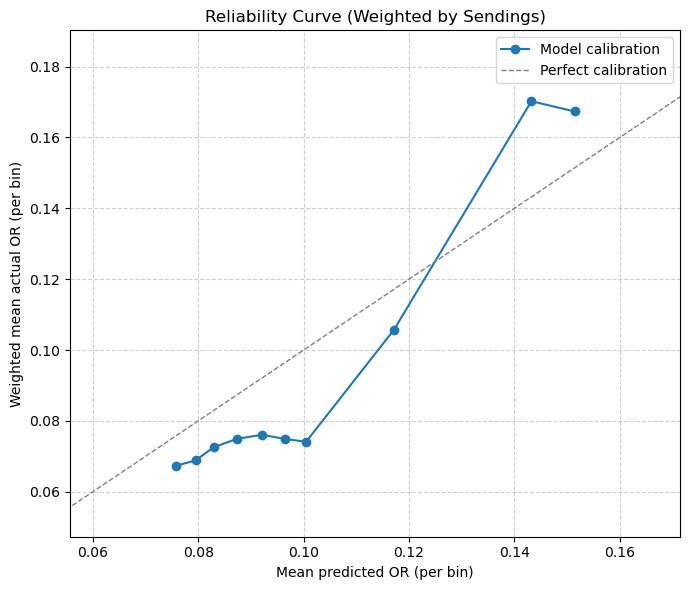


=== Weighted Calibration Table ===
   pred_mean  actual_mean  sum_weight  count
0     0.0757       0.0673  1171899.00   13.0
1     0.0795       0.0688  1869682.62   14.0
2     0.0829       0.0725  1632286.62   11.0
3     0.0874       0.0749  2164860.00   13.0
4     0.0921       0.0761  2947744.86   13.0
5     0.0965       0.0749  2310039.00   14.0
6     0.1005       0.0741  2508303.00   12.0
7     0.1171       0.1057   818946.00   11.0
8     0.1432       0.1702   542688.00   13.0
9     0.1514       0.1673   535116.00   13.0


In [11]:
#  Calibration (reliability curve )



cal_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "weight": w_test.values
}, index=X_test.index)

# Number of bins for reliability curve
n_bins = 10
cal_df["bin"] = pd.qcut(cal_df["y_pred"], q=n_bins, duplicates="drop")

# Compute weighted means per bin
agg = cal_df.groupby("bin").apply(
    lambda g: pd.Series({
        "pred_mean": np.average(g["y_pred"], weights=g["weight"]),
        "actual_mean": np.average(g["y_true"], weights=g["weight"]),
        "count": len(g),
        "sum_weight": g["weight"].sum()
    })
).reset_index(drop=True)

# Define limits based on data range (rounded up slightly)
x_min, x_max = agg["pred_mean"].min(), agg["pred_mean"].max()
y_min, y_max = agg["actual_mean"].min(), agg["actual_mean"].max()

buffer = 0.02  # small padding
xlim = (max(0, x_min - buffer), min(1, x_max + buffer))
ylim = (max(0, y_min - buffer), min(1, y_max + buffer))

# === Plot reliability curve ===
plt.figure(figsize=(7, 6))
plt.plot(agg["pred_mean"], agg["actual_mean"], marker="o", linestyle="-", label="Model calibration")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", label="Perfect calibration")

plt.xlabel("Mean predicted OR (per bin)")
plt.ylabel("Weighted mean actual OR (per bin)")
plt.title("Reliability Curve (Weighted by Sendings)")


plt.xlim(xlim)
plt.ylim(ylim)

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


agg_rounded = agg.copy()
agg_rounded[["pred_mean", "actual_mean"]] = agg_rounded[["pred_mean", "actual_mean"]].round(4)
print("\n=== Weighted Calibration Table ===")
print(agg_rounded[["pred_mean", "actual_mean", "sum_weight", "count"]])


In [12]:
# MAE on the rate 

mae_unweighted = mean_absolute_error(y_test, y_pred)

# weighted MAE (weights = sendings)
weights_arr = w_test.values
mae_weighted = np.average(np.abs(y_test.values - y_pred), weights=weights_arr)

print(f"MAE (unweighted): {mae_unweighted:.6f}")
print(f"MAE (weighted by Sendings): {mae_weighted:.6f}")


MAE (unweighted): 0.018985
MAE (weighted by Sendings): 0.017464


In [13]:
#  Top-decile lift (top 10% predictions vs overall average)


y_pred = np.clip(best_model.predict(X_test), 0, 1)
tmp = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "weight": w_test.values
}, index=X_test.index)

# overall averages
overall_mean_unweighted = tmp["y_true"].mean()
overall_mean_weighted = np.average(tmp["y_true"], weights=tmp["weight"])

# define top 10% by predicted score (row-based)
top_n = max(1, int(len(tmp) * 0.10))
top_by_pred = tmp.sort_values("y_pred", ascending=False).head(top_n)

top_mean_unweighted = top_by_pred["y_true"].mean()
top_mean_weighted = np.average(top_by_pred["y_true"], weights=top_by_pred["weight"])

lift_unweighted = top_mean_unweighted / overall_mean_unweighted if overall_mean_unweighted != 0 else np.nan
lift_weighted = top_mean_weighted / overall_mean_weighted if overall_mean_weighted != 0 else np.nan

print("Top-decile lift (unweighted):")
print(f"  top mean = {top_mean_unweighted:.6f}, overall = {overall_mean_unweighted:.6f}, lift = {lift_unweighted:.4f}")
print("Top-decile lift (weighted by Sendings):")
print(f"  top mean = {top_mean_weighted:.6f}, overall = {overall_mean_weighted:.6f}, lift = {lift_weighted:.4f}")


Top-decile lift (unweighted):
  top mean = 0.169642, overall = 0.102921, lift = 1.6483
Top-decile lift (weighted by Sendings):
  top mean = 0.170071, overall = 0.081194, lift = 2.0946


=== Weighted Permutation Importance (Top 20) ===
              Feature  Importance_Mean  Importance_STD
12       Letter_Count         0.011165        0.001910
6             Urgency         0.006448        0.000861
8   Price_or_Discount         0.002842        0.000773
9     Imperative_Tone         0.001853        0.000380
0         Day_of_week         0.000759        0.000500
7                Tone         0.000207        0.000108
1       Category_name         0.000000        0.000000
2         Main_Vs_REM         0.000000        0.000000
3   Length_Of_subject         0.000000        0.000000
4     Personalization         0.000000        0.000000
10            Product        -0.000109        0.000169
11              Month        -0.000216        0.000203
5               Emoji        -0.000535        0.000101


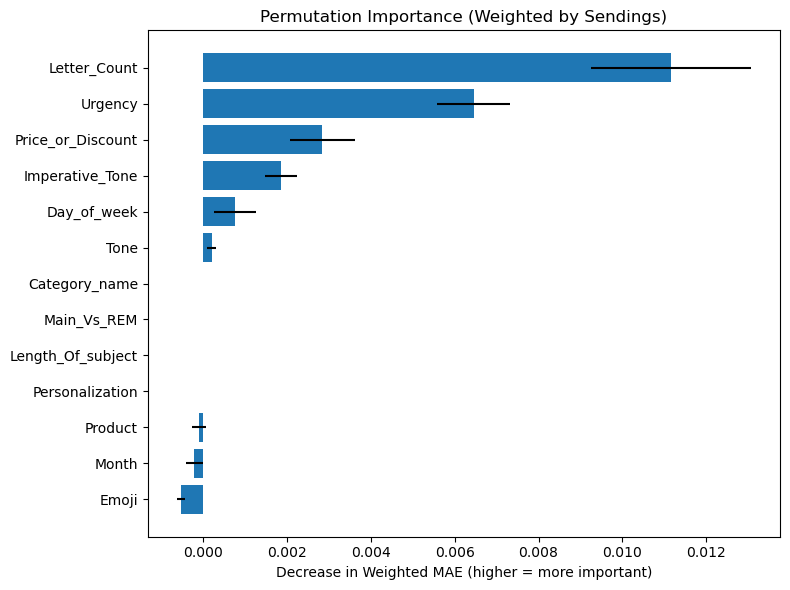

In [14]:
#  Permutation Importance 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def weighted_mae_scorer(estimator, X, y):
    y_pred = np.clip(estimator.predict(X), 0, 1)
    return -np.average(np.abs(y - y_pred), weights=w_test)  

# Run permutation importance on holdout set
r = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring=weighted_mae_scorer
)


imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": r.importances_mean,
    "Importance_STD": r.importances_std
}).sort_values("Importance_Mean", ascending=False)

# Display top 20 features
print("=== Weighted Permutation Importance (Top 20) ===")
print(imp_df.head(20))


plt.figure(figsize=(8, 6))
plt.barh(imp_df.head(20)["Feature"][::-1], imp_df.head(20)["Importance_Mean"][::-1], xerr=imp_df.head(20)["Importance_STD"][::-1])
plt.xlabel("Decrease in Weighted MAE (higher = more important)")
plt.title("Permutation Importance (Weighted by Sendings)")
plt.tight_layout()
plt.show()




In [15]:
# === Interactive LightGBM Prediction App 

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

def lgbm_predictor_widget(best_model, train_df):
    """
    Interactive widget to predict email open rate using a trained LightGBM model.
    Automatically ensures categorical features match training categories.
    """

    # -------------------------------
    #  Define model feature names
    # -------------------------------
    FEATURES = [
        'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Personalization', 'Emoji',
        'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone', 'Product',
        'Length_Of_subject', 'Month', 'Letter_Count'
    ]

    categorical_features = [
        'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Personalization', 'Emoji',
        'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone', 'Product',
        'Length_Of_subject', 'Month'
    ]

    # -------------------------------
    #  Build feature options from training data
    # -------------------------------
    feature_options = {
        col: sorted(train_df[col].dropna().unique().tolist())
        for col in categorical_features
    }

    # -------------------------------
    #  Create user input widgets
    # -------------------------------
    widgets_dict = {
        col: widgets.Dropdown(options=vals, description=col, layout=widgets.Layout(width='300px'))
        for col, vals in feature_options.items()
    }

    letter_count = widgets.IntSlider(
        value=40, min=0, max=70, step=1,
        description='Letter_Count', continuous_update=False,
        layout=widgets.Layout(width='400px')
    )

    sendings = widgets.IntText(
        value=10000, description='Sendings',
        layout=widgets.Layout(width='300px')
    )

    predict_button = widgets.Button(
        description="📬 Predict",
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )

    output = widgets.Output()

    # -------------------------------
    #  Prediction logic 
    # -------------------------------
    def on_predict_clicked(_):
        with output:
            clear_output()

            # Collect user input
            input_data = pd.DataFrame([{
                **{col: w.value for col, w in widgets_dict.items()},
                'Letter_Count': letter_count.value
            }])[FEATURES]

            # Ensure categorical dtypes match training
            for col in categorical_features:
                input_data[col] = pd.Categorical(
                    input_data[col],
                    categories=train_df[col].astype('category').cat.categories
                )

            # Predict open rate
            pred = best_model.predict(input_data)[0]
            predicted_or = pred * 100
            expected_opens = pred * sendings.value

            # Display result
            print(" **Prediction Result**")
            print(f"Predicted Open Rate: {predicted_or:.2f}%")
            print(f"Expected Opens: {expected_opens:,.0f} (out of {sendings.value:,} sent)")
            display(input_data)

    predict_button.on_click(on_predict_clicked)

    # -------------------------------
    #  Layout organization
    # -------------------------------
    form_items = [
        widgets.HBox([widgets_dict[c1], widgets_dict[c2]])
        for c1, c2 in zip(
            list(feature_options.keys())[::2],
            list(feature_options.keys())[1::2]
        )
    ]

    form = widgets.VBox(form_items + [letter_count, sendings, predict_button, output])
    display(form)

# --------------------------------
# Run the widget
# --------------------------------
lgbm_predictor_widget(best_model, df)

